## Imports

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib widget

import torch
import torch.nn as nn
import torch.utils.data as data_utils

import skorch
from skorch import NeuralNetRegressor



## Loading in dataframe

In [11]:
data_path = '../processed_data.csv'
data = pd.read_csv(data_path)
data['energy(kWh/hh)'] = data['energy(kWh/hh)'].astype(float) / data['houses']
data.info()
data.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39727 entries, 0 to 39726
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           39727 non-null  int64  
 1   timestamp       39727 non-null  object 
 2   year            39727 non-null  int64  
 3   month           39727 non-null  int64  
 4   day             39727 non-null  int64  
 5   hour            39727 non-null  int64  
 6   minute          39727 non-null  int64  
 7   day_of_week     39727 non-null  int64  
 8   weekend         39727 non-null  int64  
 9   holiday         39727 non-null  int64  
 10  energy(kWh/hh)  39727 non-null  float64
 11  houses          39727 non-null  int64  
 12  visibility      39727 non-null  float64
 13  temperature     39727 non-null  float64
 14  dewPoint        39727 non-null  float64
 15  pressure        39727 non-null  float64
 16  windSpeed       39727 non-null  float64
 17  precipType      39727 non-null 

,index,timestamp,year,month,day,hour,minute,day_of_week,weekend,holiday,energy(kWh/hh),houses,visibility,temperature,dewPoint,pressure,windSpeed,precipType,humidity
0,0,2011-11-23 09:00:00+00:00,2011,11,23,9,0,2,0,0,0.284500,2,4.390000,4.840000,4.680000,1027.290000,1.780000,0,0.990000
1,1,2011-11-23 09:30:00+00:00,2011,11,23,9,30,2,0,0,0.280500,2,5.068612,5.190130,5.095420,1027.507662,1.824055,0,0.992222
2,2,2011-11-23 10:00:00+00:00,2011,11,23,10,0,2,0,0,0.153333,6,6.240000,5.740000,5.460000,1027.670000,1.990000,0,0.980000
3,3,2011-11-23 10:30:00+00:00,2011,11,23,10,30,2,0,0,0.098000,6,8.261031,6.686929,5.598355,1027.672961,2.336091,0,0.931400
4,4,2011-11-23 11:00:00+00:00,2011,11,23,11,0,2,0,0,0.110286,7,10.200000,7.670000,5.740000,1027.560000,2.660000,0,0.880000


## Adding Input and target columns

In [44]:

data_mod = data.drop(['index','timestamp', 'year', 'houses', 'pressure', 'dewPoint'], axis=1)

data_mod['energy(kWh/hh)_prev_half'] = data_mod['energy(kWh/hh)'].shift(1)
data_mod['energy(kWh/hh)_prev_hour'] = data_mod['energy(kWh/hh)'].shift(2)
data_mod['energy(kWh/hh)_next_half'] = data_mod['energy(kWh/hh)'].shift(-1)
data_mod['energy(kWh/hh)_next_hour'] = data_mod['energy(kWh/hh)'].shift(-2)

columns = data_mod.columns.to_list()
columns.remove('energy(kWh/hh)')
columns.insert(12, 'energy(kWh/hh)')

data_mod = data_mod[columns]

## Removing Datapoints without previous or next info

In [45]:
# Removing NaN value rows
data_mod_clean = data_mod[data_mod['energy(kWh/hh)_prev_hour'].notna()]
data_mod_clean = data_mod_clean[data_mod_clean['energy(kWh/hh)_next_hour'].notna()]
data_mod_clean = data_mod_clean.reset_index(drop=True)

data_mod_clean.to_csv('../processed_data_train.csv', index=False)

## Simple Feed Forward Network

In [55]:
class ForecastNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, layers, nodes, activation=nn.Sigmoid):
        super(ForecastNetwork, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layers = layers
        self.nodes = nodes

        layers = []

        for i in range(self.layers):
            if i == 0:
                layers.append(nn.Linear(self.input_dim, self.nodes))
                layers.append(nn.BatchNorm1d(self.nodes))
            elif i == self.layers - 1:
                layers.append(nn.Linear(self.nodes, self.output_dim))
            else:
                layers.append(nn.Linear(self.nodes, self.nodes))
                layers.append(nn.BatchNorm1d(self.nodes))
            layers.append(activation())
        
        self.module = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.module(x)



## Making datasets

In [56]:
input_names = [
    'month', 
    'day', 
    'hour', 
    'minute', 
    'day_of_week', 
    'weekend', 
    'holiday', 
    'visibility', 
    'temperature', 
    'windSpeed', 
    'precipType', 
    'humidity', 
    'energy(kWh/hh)',
    'energy(kWh/hh)_prev_half', 
    'energy(kWh/hh)_prev_hour'
]

target_names = [
    'energy(kWh/hh)_next_half', 
    'energy(kWh/hh)_next_hour'
]

data_mod_clean = pd.read_csv('../processed_data_train.csv')

inputs = data_mod_clean[input_names]
targets = data_mod_clean[target_names]

input_tensor = torch.tensor(inputs.values).float()
target_tensor = torch.tensor(targets.values).float()

dataset_train = data_utils.TensorDataset(input_tensor[:int(len(input_tensor) * 0.8)], target_tensor[:int(len(target_tensor) * 0.8)])
dataset_test = data_utils.TensorDataset(input_tensor[int(len(input_tensor) * 0.8):], target_tensor[int(len(target_tensor) * 0.8):])


## Skorch Training

In [57]:
module = ForecastNetwork(input_tensor.shape[1], target_tensor.shape[1], 6, 64)

net = NeuralNetRegressor(
    module,
    max_epochs=10,
    lr=0.0001,
    batch_size=32,
    optimizer=torch.optim.Adam,
    criterion=nn.L1Loss,
    device='cuda',
    iterator_train__num_workers=4,
    iterator_train__pin_memory=True,
    iterator_valid__num_workers=4,
    iterator_valid__pin_memory=True
)

net = net.fit(dataset_train, y=None)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0843        0.0965  1.4846
      2        0.0295        0.1067  1.3886
      3        0.0258        0.1108  1.3899
      4        0.0242        0.1160  1.4637
      5        0.0232        0.1178  1.3739
      6        0.0224        0.1184  1.3956
      7        0.0220        0.1194  1.4192


## Testing Training

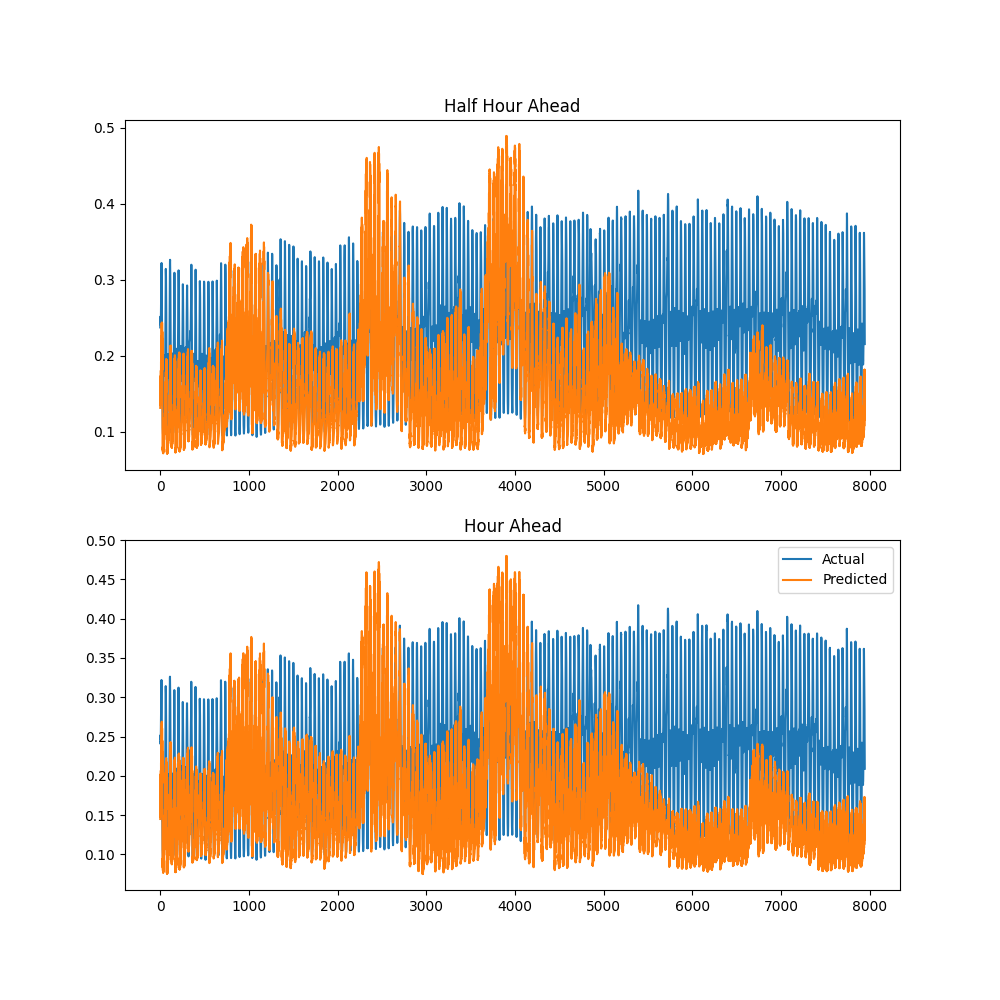

In [58]:
x_test = dataset_test[:][0]
y_test = dataset_test[:][1]

y_pred = net.predict(x_test)

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(y_test[:, 0], label='Actual')
ax[0].plot(y_pred[:, 0], label='Predicted')
ax[0].set_title('Half Hour Ahead')

ax[1].set_title('Hour Ahead')
ax[1].plot(y_test[:, 1], label='Actual')
ax[1].plot(y_pred[:, 1], label='Predicted')

plt.legend()
plt.show()